# NC Assignment: Challenge for Data Scientist
This is the notebook I used to analyze the sample data provided by NC. Each step of the analysis is described.

## Environment
The python environment for running this notebook has been setup in anaconda. The environment has been exported in a file called ```environment.yml```, which you can use to re-generate an exact copy of the working environment.

## Analysis

We start off by loading the input data into a pandas dataframe:

In [1]:
import pandas as pd

dataFilePath = '../../data/ncdatachallenge-2021-v1-1-.csv'

df = pd.read_csv(dataFilePath)

### First and second questions: probability and time of pregnancy
The goal is to answer the following questions:
1. What is the chance of getting pregnant within 13 cycles?
2. How long does it usually take to get pregnant?
   
To do so, I can focus on just two of the features that are available in the dataset: ```outcome``` and ```n_cycles_trying```. A quick check tells me that none of the two columns contain NaN values:

In [13]:
if df['outcome'].isna().any() == False:
    print(f'No NaN value in column outcome')
if df['n_cycles_trying'].isna().any() == False:
    print(f'No NaN value in column n_cycles_trying')

No NaN value in column outcome
No NaN value in column n_cycles_trying


This means I can use all the data contained in these columns without any pre-processing.

In the following cell, I am going to build two histograms, representing the distributions of the time women take to attempt to conceive (in units of number of menstrual cycles). In one histogram I collect the data referring to women who eventually got pregnant, the other refers to women who did not get pregnant.

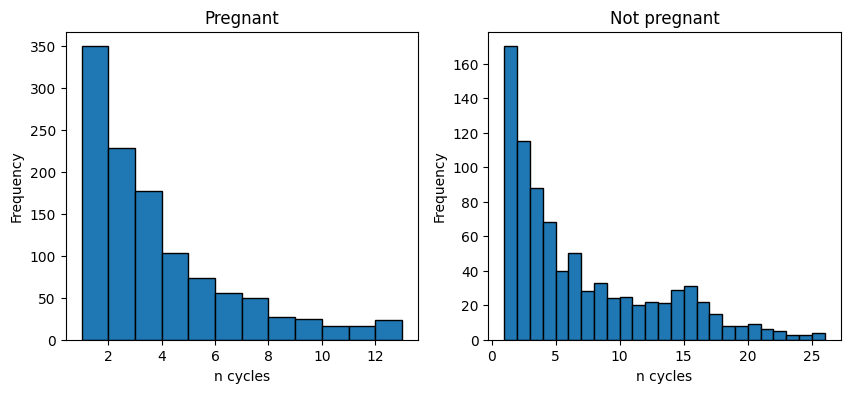

In [15]:
condition_pregnant = df['outcome'] == 'pregnant'
n_cycles_pregnant = df.loc[condition_pregnant, 'n_cycles_trying']

condition_not_pregnant = df['outcome'] == 'not_pregnant'
n_cycles_not_pregnant = df.loc[condition_not_pregnant, 'n_cycles_trying']

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].hist(n_cycles_pregnant, bins=range(min(n_cycles_pregnant), max(n_cycles_pregnant) + 1), edgecolor='black')
axes[0].set_xlabel('n cycles')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Pregnant')

axes[1].hist(n_cycles_not_pregnant, bins=range(min(n_cycles_not_pregnant), max(n_cycles_not_pregnant) + 1), edgecolor='black')
axes[1].set_xlabel('n cycles')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Not pregnant')

plt.savefig('plots/pregnancy_vs_cycles.pdf')

plt.show()

#### What is the chance of getting pregnant within 13 cycles?
The first question cannot be answered if formulated as such. The reason is that the dataset provided is biased: women who do not reach pregnancy stop trying to conceive and thus stop logging data at a *subjective point in time*. In many cases, we may safely assume that they resume contraception. To understand this more clearly, take a look at the right plot. The plot shows the distribution of the duration of the attempts to conceive for women who eventually did *not* get pregnant. The proper way to interpret this plot is as the distribution of the time it takes a woman to give up attempting. These data do not provide us with any quantitative handle for calculating probabilities, as they are the outcome of a subjective determination: we would never know whether a woman who stopped attempting would eventually have become pregnant at some point. In other words, we cannot calculate the probability of getting pregnant no-matter-what. 

More formally, what the question is asking is to calculate the conditional probability $P(pregnant|ncycles<13)$, for which one would need to use Bayes' theorem:
\begin{equation}
    P(pregnant|ncycles<13) = \frac{P(ncycles<13|pregnant)P(pregnant)}{P(ncycles<13)}
\end{equation}
However, $P(pregnant)$ cannot be calculated from the data. Neither $P(ncycles<13)$: this would be the measurement of the occurrence of less than 13 cycles in an *unbiased* dataset. Thus, we cannot answer the question *as it is*.

The only form of the question we can answer is "What is the chance of getting pregnant within 13 cycles, given that one eventually *does* get pregnant?" (namely, one never gives up attempting). This would correspond to the $P(ncycles<13|pregnant)$ term in Bayes' equation above, and can be deduced from the left plot. The histogram shows that this chance is 100\%: of all women who eventually got pregnant, the duration of the attempt had been less than 13 cycles.

#### How long does it usually take to get pregnant?

To answer this question, we refer again to the distribution of the number of cycles shown in the left plot above, the one referring to women who eventyally got pregnant. Assuming that the two subsamples (outcome=pregnant and outcome=not\_pregnant) are both well representative of the population, the shape of this distribution is unaffected by what happens to the same distribution for women who did not conceive (the right plot), save for statistical fluctuations. As a consequence, we may interpret its momenta as quantitative information on the conception time. Let's calculate mean, rms and median:

In [17]:
import numpy as np

print(f'Mean time   = {n_cycles_pregnant.mean()} cycles')
print(f'Rms time    = {np.sqrt(n_cycles_pregnant.var())} cycles')
print(f'Median time = {n_cycles_pregnant.median()} cycles')

Mean time   = 3.3754355400696863 cycles
Rms time    = 2.733305078852373 cycles
Median time = 2.0 cycles


We may thus say that, upon using NC Plan Pregnancy, it takes an average of $3.4\pm2.7$ cycles to finally conceive. As the distribution is highly asymmetric, it is of great use to mention its median, whose value is $2.0$: for 50\% of women it takes less than 2 cycles to conceive.

### Third question: What factors impact the time it takes to get pregnant?

In [ ]:
from sklearn.preprocessing import LabelEncoder

alphanumerical_columns = ['country', 'been_pregnant_before', 'education', 'sleeping_pattern', 'outcome', 'regular_cycle']

label_encoder = list()
for column in alphanumerical_columns:
    new_label_encoder = LabelEncoder()
    df[column] = new_label_encoder.fit_transform(df[column])
    label_encoder.append(new_label_encoder)

for i in range(len(label_encoder)):    
    print(f'{alphanumerical_columns[i]}: {label_encoder[i].classes_}')

In [ ]:
print(df)

In [ ]:
for column in df.columns:
    value_counts = df[column].value_counts()
    plt.hist(df[column], bins=10, edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()

In [ ]:
'''
Reinserting NaN's
'''

for i in range(len(label_encoder)):    
    nan_index = len(label_encoder[i].classes_)-1
    value = label_encoder[i].classes_[nan_index]
    print(nan_index, " -> ", type(value))
    if isinstance(value, float):
        df.loc[df[alphanumerical_columns[i]] == nan_index, alphanumerical_columns[i]] = np.nan

nan_counts = df.isna().sum()
print("NaN counts in each column:")
print(nan_counts)

print(df)

In [ ]:
'''
Substituting NaN's with statistical sample
'''

for column in df.columns:
    value_counts = df[column].dropna().value_counts()
    #print(value_counts)
    values = value_counts.index
    probabilities = value_counts / value_counts.sum()
    random_number = np.random.choice(values, p=probabilities)
    #print('RRRRRRRRRRRRRRRRRRRRRRRRR = ', random_number)
    df.loc[np.isnan(df[column]), column] = random_number
'''
    plt.hist(df[column], bins=10, edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()
    '''

for column in df.columns:
    plt.hist(df[column], bins=10, edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()

In [ ]:
'''
One-hot is better than label encoding, because there's no numerical contiguity in the values
'''

for column in alphanumerical_columns:
    df = pd.get_dummies(df, columns=[column], prefix=column)
    
print(df)
#df.to_csv('tmp.csv', index=False)

In [ ]:
import seaborn as sns

correlation_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix')
plt.show()

In [ ]:
'''
THIS ONE IS USELESS AT THIS POINT
'''

condition = df['outcome_1'] == 1
df_pregnant = df[condition]

correlation_matrix = df_pregnant.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix')
plt.show()

In [ ]:
regex_to_exclude = 'country*'
filtered_df = df.filter(regex=f'^(?!{regex_to_exclude}).*$', axis=1)

correlation_matrix = filtered_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix')
plt.show()

print(correlation_matrix['outcome_1'])